Simulate what a curator would do when following the proposed pipeline in the scenario where the modeler did not do their job correctly. 

In [1]:
import numpy as np
import os
import json
import matplotlib.pyplot as plt

import sim_lib

res_dir = os.path.join('results', 'workflow_sim_1')

In [2]:
fp = os.path.join(res_dir, 'sim_modeler.json')
with open(fp, 'r') as f:
    modeler_metadata = sim_lib.Metadata.from_json(json.load(f))

In [3]:
model_string_antimony = """
species S, I, R, V;

S -> I ; beta * S * V;
I -> R ; delta * I;
-> V  ; p * I - k * V;

S = 1E6;
I = 0.0;
R = 0.0;
V = 2.0;

beta = 1.0E-6;
k = 4.0;
delta = 1E0;
p = 25.0;
"""
stochastic = modeler_metadata.simulator == 'gillespie_ssa'
t_fin = modeler_metadata.sample_times[-1]
num_steps = modeler_metadata.sample_times.shape[0]
ecf_eval_info = modeler_metadata.ecf_eval_info

model_string_sbml = sim_lib.antimony_to_sbml(model_string_antimony)
var_names = list(modeler_metadata.ecf_evals.keys())

param_dists = {pd.param_name: (pd.dist_name, pd.dist_params) for pd in modeler_metadata.param_dists}

# Impose a difference
param_dists['beta'] = (param_dists['beta'][0], (param_dists['beta'][1][0] * 0.5, param_dists['beta'][1][1]))

Generate data from curator's implementation

In [4]:
results = dict()
for name in var_names:
    results[name] = np.zeros((2*modeler_metadata.sample_size, num_steps))

rr = sim_lib.make_rr(model_string_sbml, stochastic)

sim_lib.start_pool()
for i, res in enumerate(sim_lib.exec_rr_batch(2*modeler_metadata.sample_size, rr, t_fin, num_steps, stochastic, dists=param_dists)):
    for name in var_names:
        results[name][i, :] = res[:, res.colnames.index(f'[{name}]')]

sample_times = rr.simulate(0, t_fin, num_steps)['time']

Show results, for reference

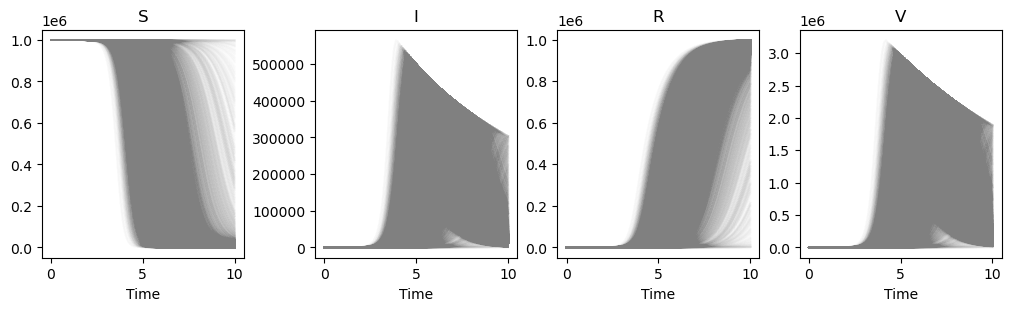

In [5]:
fig, axs = plt.subplots(1, len(var_names), figsize=(10.0, 3.0), layout='compressed')
for i, name in enumerate(var_names):
    for j in range(results[name].shape[0]):
        axs[i].plot(sample_times, results[name][j, :], alpha=0.01, color='gray')
    axs[i].set_title(name)
    axs[i].set_xlabel('Time')

Test against modeler's sampling data

In [6]:
sampling_err_thresh = 0.001
ks_stats_samp = sim_lib.test_sampling(results, err_thresh=sampling_err_thresh)[0]
print('Curator\'s K-S statistics:', np.average(ks_stats_samp), np.std(ks_stats_samp))
print('Modeler\'s K-S statistics:', modeler_metadata.ks_stat_mean, modeler_metadata.ks_stat_stdev)

Curator's K-S statistics: 0.057274425649270135 0.006074042560823794
Modeler's K-S statistics: 0.05450077969917837 0.00646541729108952


Test against modeler's data

Maximum error: 1.8230504189948422


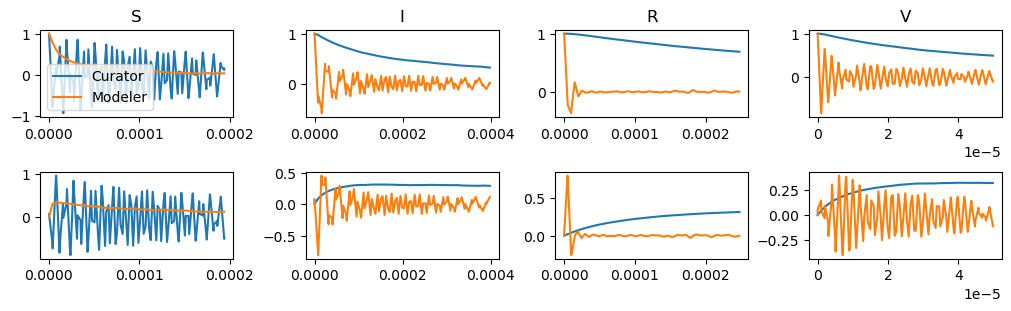

In [7]:
err_max = 0.0
res_oi_idx = 0
for name in var_names:
    for i in range(num_steps):
        ecf_curator = sim_lib.ecf(results[name][:, i][:modeler_metadata.sample_size].T, 
                                  sim_lib.get_eval_info_times(*ecf_eval_info[name][i]))
        err_i = sim_lib.ecf_compare(ecf_curator, modeler_metadata.ecf_evals[name][i])
        if err_i > err_max:
            res_oi_idx = i
            err_max = err_i

fig, axs = plt.subplots(2, len(var_names), figsize=(10.0, 3.0), layout='compressed')
for j, name in enumerate(var_names):
    eval_t = sim_lib.get_eval_info_times(*ecf_eval_info[name][res_oi_idx])
    ecf_curator = sim_lib.ecf(results[name][:, res_oi_idx], eval_t)
    ecf_modeler = modeler_metadata.ecf_evals[name][res_oi_idx]
    for i in range(2):
        axs[i, j].plot(eval_t, ecf_curator[:, i], label='Curator')
        axs[i, j].plot(eval_t, ecf_modeler[:, i], label='Modeler')
    axs[0, j].set_title(name)
axs[0, 0].legend()

print('Maximum error:', err_max)

Record data

In [8]:
with open(os.path.join(res_dir, 'simdata_curator_fail.json'), 'w') as f:
    json.dump(dict(sample_size=2*modeler_metadata.sample_size,
                   sampling_err_thresh=sampling_err_thresh,
                   err_max=err_max,
                   results_times=sample_times.tolist(),
                   results={n: results[n].tolist() for n in var_names},
                   ks_stats_samp=ks_stats_samp), 
              f, indent=4)